In [1]:
import ipympl

In [13]:
# At first all necessary Python packages are imported that are required for doing the job

import numpy as np# NumPy is the standard package for numerical calculations in Python. For less typing and better reading, numpy is renamed to a shorter abbreviation np
from matplotlib import pyplot as plt # PyPlot is the standard subpackage from MatPlotLib for data visualization in Python. For less typing and better reading, pyplot is renamed to a shorter abbreviation plt
import math # for mathematical standard functions
import scipy as sc # for signal processing
# This socalled "magical command" tells JupyterLab to create all plots and figures inside the below textflow with interactive zoom functionality for better data investigation
%matplotlib widget

In [3]:
# Specify filename with extension to be read in
fname='22050210.055'

# np.genfromtxt is a function that reads in data from a (text-)file.
# the function is documented in detail here: https://numpy.org/doc/2.1/reference/generated/numpy.genfromtxt.html
# here we read in the file with name "fname", specify the symbol that delimits the individual columns (tab symbol), skip the first 5 lines because they are just metainformation and column names
data=np.genfromtxt(fname,skip_header=19)

In [4]:
print(data.shape) # This prints the data array
print(data[0]) # Print the first data row and check whether it is really the first data row from the text file

(4515, 10)
[ 1.872e+03  2.000e+00  4.050e+02 -0.000e+00 -2.630e+02  1.000e+00
  1.000e+00 -2.630e+02  2.100e+02  1.950e+02]


Baseline level:  149.08800000000002


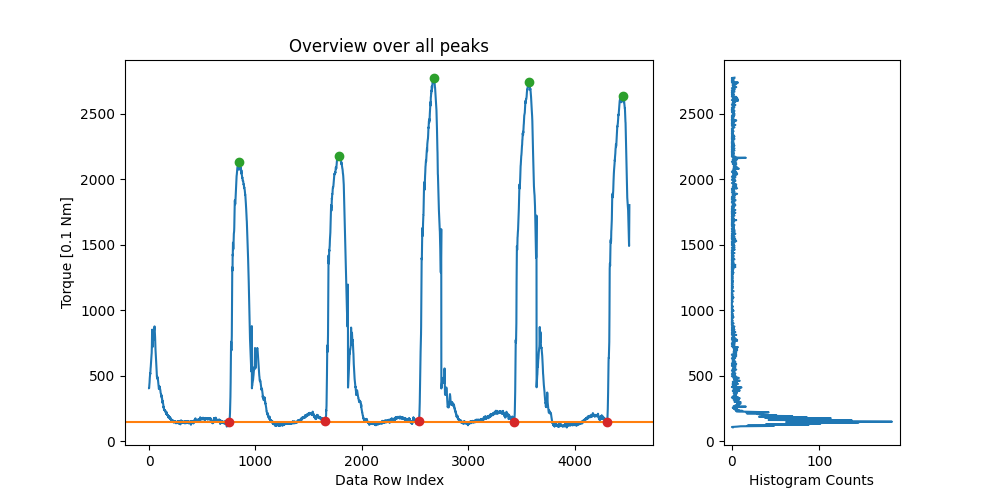

In [23]:
# Here we will first look at the torque data
fig=plt.figure(figsize=(10,5)) # creates a new figure
gs = fig.add_gridspec(1, 2,  width_ratios=(3, 1))
ax=fig.add_subplot(gs[0]) # adds one plot to the figure
torque=data[:,2]
ax.plot(np.arange(0,data.shape[0]),torque) # plot Row index (starting from 0) vs Torque (Column 3)
ax.set_xlabel('Data Row Index')
ax.set_ylabel('Torque [0.1 Nm]')
ax.set_title('Overview over all peaks')

# For determining a good baseline, we plot the histogram of the dataseries and take the most frequent value as the baseline
ax2=fig.add_subplot(gs[1],sharey=ax)
hist,bin_edges=np.histogram(torque,bins=1000)
ax2.plot(hist,0.5*(bin_edges[:-1]+bin_edges[1:]))
ax2.set_xlabel('Histogram Counts')
baseline=0.5*(bin_edges[:-1]+bin_edges[1:])[np.argmax(hist)]
ax.axhline(y=baseline,color='C1')
print('Baseline level: ',baseline)

# For determining the peak start positions, specified by baseline level +2% of it
peaks_indices,_=sc.signal.find_peaks(torque,height=0.5*np.max(torque),distance=500) # find all peaks that have a minimum height of 50% of the data maximum and that are spaced at least 500 pixels
ax.plot(peaks,torque[peaks_indices],linestyle='None',marker='o',color='C2')
peakstarts_indices=[]
for i in peaks_indices:
    torque_minus_baseline=torque[:i]-1.02*baseline
    startindex=np.argwhere(np.sign(torque_minus_baseline)==-1)[-1] # find peak start by finding the pixel which is just below the 1.02*baseline level
    peakstarts_indices.append(startindex)
ax.plot(peakstarts_indices,torque[peakstarts_indices],linestyle='None',marker='o',color='C3')

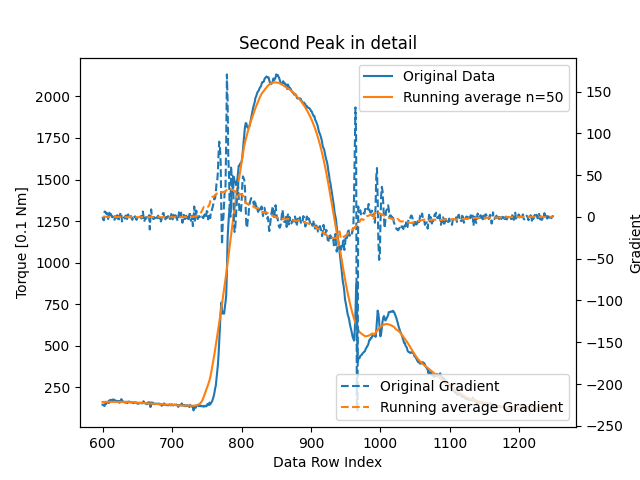

In [6]:
# In the next plot we choose only the second peak for a more detailed and isolated investigation
# The correct start and end indices of the second peak can easily be determined from the x axis of the plot above
# Hovering with the mouse over the plot above makes the current coordinates appear in real time below the plot
fig=plt.figure() # creates a new figure
ax=fig.add_subplot(111) # adds one plot to the figure
start_index,end_index=600,1250
line1=ax.plot(np.arange(start_index,end_index),data[start_index:end_index,2],label='Original Data') # plot Row index (starting from 0) vs Torque (Column 3)
ax.set_xlabel('Data Row Index')
ax.set_ylabel('Torque [0.1 Nm]')
ax.set_title('Second Peak in detail')

# Now let's plot the derivative (=gradient) of the original data with the help of a second y-axis
ax2=ax.twinx()
gradientline1=ax2.plot(np.arange(start_index,end_index),np.gradient(data[start_index:end_index,2]),label='Original Gradient',linestyle='--')
ax2.set_ylabel('Gradient')

# calculate and plot the running average with specified window_length

# Numpy does have easy ways for calculating a running average (see https://stackoverflow.com/questions/13728392/moving-average-or-running-mean),
# but there is no ready-to-use function for calculating the running average that corrects for the shift effect and has an adaptive window_length for the first and last points,
# so let's make our own running anverage function that does the job
def running_average(array_1D,window_length=3):
    """
        array_1D: 1-dimensional array or list
        window_length: max number of points to be averaged per original data point. will be less for the first and last few data points. Default=3
    """
    # Initialize a new array of the same size as the original array filled with zeros
    new_array=np.zeros(array_1D.shape)
    for i in range(0,array_1D.size):
        window_startindex,window_endindex=i-math.ceil(window_length/2)+1,i+int(window_length/2) # calculate start and end indices of the symmetric window around data point i
        if window_startindex<0:
            window_startindex=0 # The window startindex can never be negative
        if window_endindex>=array_1D.size:
            window_endindex=array_1D.size # The window endindex can never be bigger than the index of the last data point
        new_array[i]=np.mean(array_1D[window_startindex:window_endindex]) # calculates the mean of the window
    return new_array # returns the running average of the original array without shift effect 
    
window_length=50 # specify the window_length, play around and see how it changes in the plot below
# The line below is short but messy, because it's nesting the running_average function into the plotting function
# Alternatively you could first define a new array for calculating and saving the running average and then put this into the plotting function
line2=ax.plot(np.arange(start_index,end_index),running_average(data[start_index:end_index,2],window_length=window_length),label='Running average n='+str(window_length))
# Now let's plot the derivative (=gradient) of the smoothened data
gradientline2=ax2.plot(np.arange(start_index,end_index),np.gradient(running_average(data[start_index:end_index,2],window_length=window_length)),label='Running average Gradient',linestyle='--')

legend=ax.legend(loc='upper right') # generate an automativ plot legend based on the labels that were specified in the previous plot functions
ax2.legend(loc='lower right')

(1000, 4515, 10)


Text(0.5, 1.0, 'Second Peak in detail')

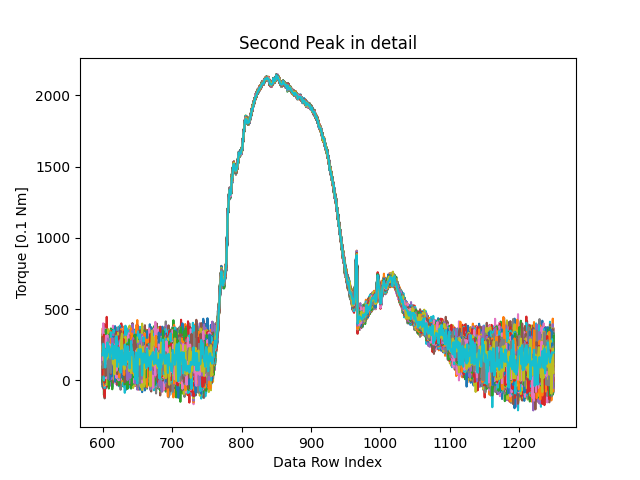

In [7]:
# Now let's generate 999 more data sets from the one we have, to simulate the case in which we have 1000 different files
repeats=1000
data_sets=np.repeat(data[np.newaxis,:,:], repeats, axis=0)
print(data_sets.shape) # print the shape of the complete data_sets array

# Let's add a random noise to the torque column to make the 1000 different data sets look different
# the additional noise data is generated from a normal distribution with specified standard deviation
std=1e4 # standard deviation of the added normal noise
data_sets[:,:,2]+=np.random.normal(scale=std,size=data_sets.shape[:2])/data_sets[:,:,2]

# Now let's plot all the 1000 data series in one new plot
# For better visability the individual plots are automatically colored differently
fig=plt.figure() # creates a new figure
ax=fig.add_subplot(111) # adds one plot to the figure
for i in range(0,data_sets.shape[0]):
    line1=ax.plot(np.arange(start_index,end_index),data_sets[i,start_index:end_index,2]) # plot Row index (starting from 0) vs Torque (Column 3)
ax.set_xlabel('Data Row Index')
ax.set_ylabel('Torque [0.1 Nm]')
ax.set_title('Second Peak in detail')

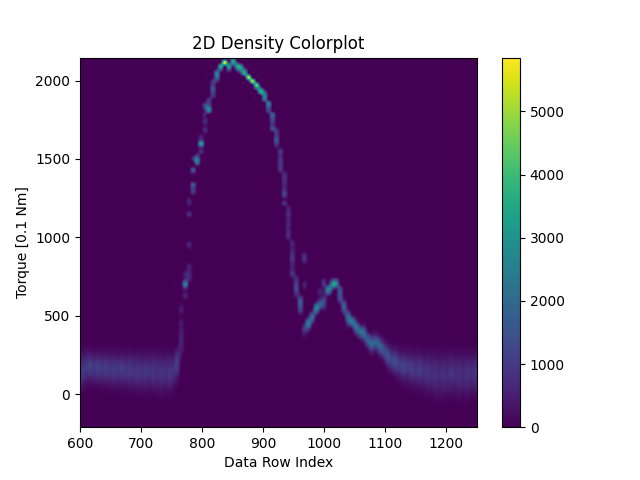

In [8]:
# This is a messy visualisation that does not allow to see what's happening very good
# Fortunately we can visualize this in the form of a 2D histogram that indicates the density of points as a color
# So areas in which points of all data series are more concentrated will be colored stronger
fig=plt.figure() # creates a new figure
ax=fig.add_subplot(111) # adds one plot to the figure

bins=(100,100) # number of bins of the histogram
# The hist2d function below calculates the 2d histogram and plots it at the same time
# hist=ax.hist2d(np.array([np.arange(start_index,end_index) for i in data_sets]).flatten(),data_sets[:,start_index:end_index,2].flatten(),bins=bins)

# Alternatively you can calculate and visualize the 2d histogram in two separate steps
# That has the advantage that you can visualize the 2d histogram separately with interpolation feature, which creates a smooth looking colorplot
hist2d,xedges,yedges=np.histogram2d(np.array([np.arange(start_index,end_index) for i in data_sets]).flatten(),data_sets[:,start_index:end_index,2].flatten(),bins=bins)
image=ax.imshow(hist2d.T[::-1],extent=(start_index,end_index,yedges[0],yedges[-1]),aspect='auto',interpolation='spline36')

ax.set_xlabel('Data Row Index')
ax.set_ylabel('Torque [0.1 Nm]')
ax.set_title('2D Density Colorplot')
fig.colorbar(image)

In [9]:
# In the plot above the dominant peaks are common to all data sets
# whereas the baseline signal is very different for the different data sets